# Policy Gradient Methods Tutorial

## A Comprehensive Guide to Policy-Based Reinforcement Learning

This tutorial covers policy gradient methods, a powerful family of reinforcement learning algorithms that directly optimize the policy function. We'll explore REINFORCE, Actor-Critic methods, and advanced techniques using the CartPole environment.

### Table of Contents
1. [Introduction to Policy Gradient Methods](#introduction)
2. [REINFORCE Algorithm](#reinforce)
3. [Actor-Critic Methods](#actor-critic)
4. [Summary and Next Steps](#summary)
5. [Comparison and Analysis](#comparison)
6. [Visualizations](#visualizations)

---


## 1. Introduction to Policy Gradient Methods {#introduction}

### What are Policy Gradient Methods?

Policy gradient methods are a class of reinforcement learning algorithms that directly optimize the policy function $\pi(a|s)$ without needing to learn a value function first. Unlike value-based methods (like Q-learning), policy gradient methods:

- **Directly optimize the policy**: They learn the policy parameters $\theta$ to maximize expected return
- **Handle continuous action spaces**: Can naturally work with continuous actions
- **Stochastic policies**: Can learn stochastic (probabilistic) policies
- **Better convergence properties**: Often more stable than value-based methods

### The Policy Gradient Theorem

The fundamental result that makes policy gradient methods work is the **Policy Gradient Theorem**:

$$\nabla_\theta J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta} \left[ \sum_{t=0}^{T} \nabla_\theta \log \pi_\theta(a_t|s_t) \cdot A_t \right]$$

Where:
- $J(\theta)$ is the expected return (objective function)
- $\pi_\theta(a|s)$ is the policy parameterized by $\theta$
- $A_t$ is the advantage function
- $\tau$ represents a trajectory

### Key Concepts

1. **Policy**: $\pi(a|s)$ - probability of taking action $a$ in state $s$
2. **Return**: $G_t = \sum_{k=t}^{T} \gamma^k r_{t+k+1}$ - discounted cumulative reward
3. **Value Function**: $V^\pi(s) = \mathbb{E}[G_t | s_t = s]$ - expected return from state $s$
4. **Advantage Function**: $A^\pi(s,a) = Q^\pi(s,a) - V^\pi(s)$ - how much better action $a$ is than average

---


## 2. REINFORCE Algorithm {#reinforce}

### Overview

REINFORCE (REward Increment = Nonnegative Factor × Offset Reinforcement × Characteristic Eligibility) is the simplest policy gradient algorithm. It uses the complete return $G_t$ as an unbiased estimate of the advantage.

### Algorithm Steps

1. **Collect trajectories** by following the current policy
2. **Calculate returns** $G_t$ for each time step
3. **Update policy parameters** using the policy gradient

### Mathematical Foundation

For REINFORCE, we use $A_t = G_t$ (the return), giving us:

$$\nabla_\theta J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta} \left[ \sum_{t=0}^{T} \nabla_\theta \log \pi_\theta(a_t|s_t) \cdot G_t \right]$$

The parameter update is:

$$\theta_{t+1} = \theta_t + \alpha \nabla_\theta J(\theta)$$

### Implementation

Let's implement REINFORCE for the CartPole environment:


In [24]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gymnasium as gym
from collections import deque
import random
from IPython.display import Image, display
import matplotlib.animation as animation
from matplotlib.patches import Rectangle, Circle
from PIL import Image as PILImage
import io
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12


Using device: cpu


In [25]:
class PolicyNetwork(nn.Module):
    """Neural network for policy approximation"""
    
    def __init__(self, state_size, action_size, hidden_size=128):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        action_probs = F.softmax(self.fc3(x), dim=-1)
        return action_probs

In [ ]:
class REINFORCEAgent:
    """REINFORCE implementation with proper episode handling"""
    
    def __init__(self, state_size, action_size, lr=1e-3, gamma=0.99):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        
        # Policy network
        self.policy = PolicyNetwork(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        
        # Episode storage - each episode is stored separately
        self.episodes = []
        self.current_episode = {'states': [], 'actions': [], 'rewards': []}
        
    def act(self, state, training=True):
        """Select action using current policy"""
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        action_probs = self.policy(state)
        
        if training:
            # Sample action from policy
            action_dist = torch.distributions.Categorical(action_probs)
            action = action_dist.sample()
            return action.item()
        else:
            # Greedy action selection
            return action_probs.argmax().item()
    
    def store_transition(self, state, action, reward):
        """Store transition for current episode"""
        self.current_episode['states'].append(state)
        self.current_episode['actions'].append(action)
        self.current_episode['rewards'].append(reward)
    
    def end_episode(self):
        """End current episode and store it"""
        if len(self.current_episode['states']) > 0:
            self.episodes.append(self.current_episode.copy())
            self.current_episode = {'states': [], 'actions': [], 'rewards': []}
    
    def calculate_returns(self, rewards):
        """Calculate discounted returns for a single episode"""
        returns = []
        G = 0
        
        # Calculate returns in reverse order
        for reward in reversed(rewards):
            G = reward + self.gamma * G
            returns.insert(0, G)
        
        return returns
    
    def update_policy(self, batch_size=None):
        """Update policy using REINFORCE algorithm"""
        if len(self.episodes) == 0:
            return None
        
        # Collect all states, actions, and returns from all episodes
        all_states = []
        all_actions = []
        all_returns = []
        
        for episode in self.episodes:
            if len(episode['states']) > 0:
                # Calculate returns for this episode
                episode_returns = self.calculate_returns(episode['rewards'])
                
                all_states.extend(episode['states'])
                all_actions.extend(episode['actions'])
                all_returns.extend(episode_returns)
        
        if len(all_states) == 0:
            return None
        
        # Convert to tensors
        states = torch.FloatTensor(all_states).to(device)
        actions = torch.LongTensor(all_actions).to(device)
        returns = torch.FloatTensor(all_returns).to(device)
        
        # Normalize returns (optional but often helpful)
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)
        
        # Calculate policy loss
        action_probs = self.policy(states)
        action_dist = torch.distributions.Categorical(action_probs)
        log_probs = action_dist.log_prob(actions)
        
        # REINFORCE loss (negative because we want to maximize)
        loss = -(log_probs * returns).mean()  # Use mean instead of sum for stability
        
        # Update policy
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # Clear all episodes
        self.episodes = []
        
        return loss.item()

print("REINFORCE agent implementation complete!")


REINFORCE agent implementation complete!


In [28]:
def train_reinforce(env, agent, episodes=1000, max_steps=500, update_frequency=10):
    """Train REINFORCE agent with proper episode handling"""
    scores = []
    losses = []
    
    for episode in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        
        for step in range(max_steps):
            # Select action
            action = agent.act(state, training=True)
            
            # Take action
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            # Store transition
            agent.store_transition(state, action, reward)
            
            state = next_state
            total_reward += reward
            
            if done:
                # End episode and store it
                agent.end_episode()
                break
        
        scores.append(total_reward)
        
        # Update policy every update_frequency episodes
        if (episode + 1) % update_frequency == 0:
            loss = agent.update_policy()
            if loss is not None:
                losses.append(loss)
        
        # Print progress
        if episode % 100 == 0:
            avg_score = np.mean(scores[-100:])
            print(f"Episode {episode}, Average Score: {avg_score:.2f}")
    
    return scores, losses

print(" REINFORCE training function ready!")


 REINFORCE training function ready!


In [29]:
# Create environment and agent
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

print(f"Environment: {env.spec.id}")
print(f"State size: {state_size}")
print(f"Action size: {action_size}")
print(f"State space: {env.observation_space}")
print(f"Action space: {env.action_space}")

# Create REINFORCE agent
reinforce_agent = REINFORCEAgent(state_size, action_size, lr=1e-3, gamma=0.99)
print("\nREINFORCE agent created!")


Environment: CartPole-v1
State size: 4
Action size: 2
State space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
Action space: Discrete(2)

REINFORCE agent created!


In [32]:
# Train REINFORCE agent
print("Training REINFORCE agent...")
reinforce_scores, reinforce_losses = train_reinforce(env, reinforce_agent, episodes=1000, max_steps=500)
print("Training complete!")


Training REINFORCE agent...
Episode 0, Average Score: 500.00
Episode 100, Average Score: 423.44
Episode 200, Average Score: 425.55
Episode 300, Average Score: 467.26
Episode 400, Average Score: 472.18
Episode 500, Average Score: 481.41
Episode 600, Average Score: 480.42
Episode 700, Average Score: 482.30
Episode 800, Average Score: 446.07
Episode 900, Average Score: 484.72
Episode 1000, Average Score: 487.81
Episode 1100, Average Score: 484.24
Episode 1200, Average Score: 496.18
Episode 1300, Average Score: 496.72
Episode 1400, Average Score: 496.57
Episode 1500, Average Score: 493.39
Episode 1600, Average Score: 496.96
Episode 1700, Average Score: 496.08
Episode 1800, Average Score: 500.00
Episode 1900, Average Score: 483.54
Training complete!


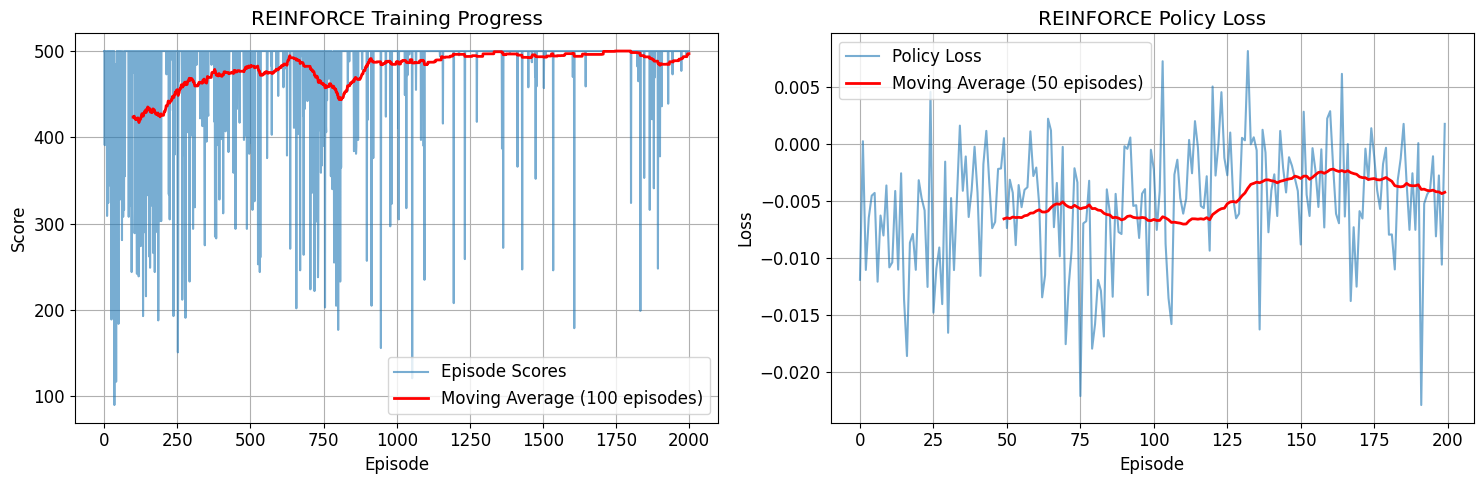


Final 100-episode average score: 496.98
Maximum score achieved: 500.0
Episodes to solve (score > 195): 0


In [33]:
# Plot REINFORCE results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot scores
ax1.plot(reinforce_scores, alpha=0.6, label='Episode Scores')
if len(reinforce_scores) > 100:
    window = 100
    moving_avg = np.convolve(reinforce_scores, np.ones(window)/window, mode='valid')
    ax1.plot(range(window-1, len(reinforce_scores)), moving_avg, 'r-', linewidth=2, 
             label=f'Moving Average ({window} episodes)')
ax1.set_xlabel('Episode')
ax1.set_ylabel('Score')
ax1.set_title('REINFORCE Training Progress')
ax1.legend()
ax1.grid(True)

# Plot losses
if reinforce_losses:
    ax2.plot(reinforce_losses, alpha=0.6, label='Policy Loss')
    if len(reinforce_losses) > 50:
        window = 50
        moving_avg_loss = np.convolve(reinforce_losses, np.ones(window)/window, mode='valid')
        ax2.plot(range(window-1, len(reinforce_losses)), moving_avg_loss, 'r-', linewidth=2, 
                 label=f'Moving Average ({window} episodes)')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Loss')
    ax2.set_title('REINFORCE Policy Loss')
    ax2.legend()
    ax2.grid(True)

plt.tight_layout()
plt.show()

# Print final statistics
final_avg_score = np.mean(reinforce_scores[-100:])
print(f"\nFinal 100-episode average score: {final_avg_score:.2f}")
print(f"Maximum score achieved: {max(reinforce_scores)}")
print(f"Episodes to solve (score > 195): {next((i for i, score in enumerate(reinforce_scores) if score >= 195), 'Not solved')}")


## 3. Actor-Critic Methods {#actor-critic}

### Overview

Actor-Critic methods combine the benefits of policy gradient methods with value function approximation. They use two networks:

1. **Actor**: The policy network that selects actions
2. **Critic**: The value network that estimates state values

### Key Advantages

- **Reduced variance**: Using value function estimates instead of full returns
- **Online learning**: Can update after each step, not just after episodes
- **Better sample efficiency**: More stable than pure policy gradient methods

### Mathematical Foundation

The Actor-Critic update uses the advantage function $A(s,a) = Q(s,a) - V(s)$:

$$\nabla_\theta J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta} \left[ \sum_{t=0}^{T} \nabla_\theta \log \pi_\theta(a_t|s_t) \cdot A_t \right]$$

Where $A_t = r_{t+1} + \gamma V(s_{t+1}) - V(s_t)$ (TD error)

### Implementation

Let's implement an Actor-Critic agent:


In [ ]:
class ValueNetwork(nn.Module):
    """Neural network for value function approximation"""
    
    def __init__(self, state_size, hidden_size=128):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        value = self.fc3(x)
        return value

class ActorCriticAgent:
    """Actor-Critic algorithm with better training stability"""
    
    def __init__(self, state_size, action_size, lr_actor=3e-4, lr_critic=1e-3, gamma=0.99, 
                 entropy_coef=0.01, value_coef=0.5, max_grad_norm=0.5):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.entropy_coef = entropy_coef
        self.value_coef = value_coef
        self.max_grad_norm = max_grad_norm
        
        # Actor (policy) network
        self.actor = PolicyNetwork(state_size, action_size).to(device)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr_actor)
        
        # Critic (value) network
        self.critic = ValueNetwork(state_size).to(device)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr_critic)
        
        # Experience buffer for batch updates
        self.states = []
        self.actions = []
        self.rewards = []
        self.next_states = []
        self.dones = []
        
    def act(self, state, training=True):
        """Select action using current policy"""
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        action_probs = self.actor(state)
        
        if training:
            # Sample action from policy
            action_dist = torch.distributions.Categorical(action_probs)
            action = action_dist.sample()
            return action.item()
        else:
            # Greedy action selection
            return action_probs.argmax().item()
    
    def get_value(self, state):
        """Get state value from critic"""
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        return self.critic(state)
    
    def store_transition(self, state, action, reward, next_state, done):
        """Store transition in experience buffer"""
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.next_states.append(next_state)
        self.dones.append(done)
    
    def clear_buffer(self):
        """Clear experience buffer"""
        self.states = []
        self.actions = []
        self.rewards = []
        self.next_states = []
        self.dones = []
    
    def update(self, batch_size=32):
        """Update both actor and critic networks with better stability"""
        if len(self.states) < batch_size:
            return None, None
        
        # Convert to tensors
        states = torch.FloatTensor(self.states).to(device)
        actions = torch.LongTensor(self.actions).to(device)
        rewards = torch.FloatTensor(self.rewards).to(device)
        next_states = torch.FloatTensor(self.next_states).to(device)
        dones = torch.BoolTensor(self.dones).to(device)
        
        # Get current values and next values
        values = self.critic(states).squeeze()
        next_values = self.critic(next_states).squeeze()
        
        # Calculate TD targets with proper handling of terminal states
        td_targets = rewards + self.gamma * next_values * (~dones)
        advantages = td_targets - values
        
        # Critic loss (MSE) - ensure proper tensor shapes
        critic_loss = F.mse_loss(values, td_targets.detach())
        
        # Actor loss (policy gradient with advantage)
        action_probs = self.actor(states)
        action_dist = torch.distributions.Categorical(action_probs)
        log_probs = action_dist.log_prob(actions)
        
        # Policy loss with advantage
        policy_loss = -(log_probs * advantages.detach()).mean()
        
        # Entropy bonus for exploration
        entropy_loss = -action_dist.entropy().mean()
        
        # Total actor loss
        actor_loss = policy_loss + self.entropy_coef * entropy_loss
        
        # Update critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic.parameters(), self.max_grad_norm)
        self.critic_optimizer.step()
        
        # Update actor
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor.parameters(), self.max_grad_norm)
        self.actor_optimizer.step()
        
        # Clear buffer
        self.clear_buffer()
        
        return actor_loss.item(), critic_loss.item()

print("Actor-Critic agent implementation complete!")


Actor-Critic agent implementation complete!


In [ ]:
def train_actor_critic(env, agent, episodes=1000, max_steps=500, update_frequency=10, batch_size=32):
    """Train Actor-Critic agent with better stability"""
    scores = []
    actor_losses = []
    critic_losses = []
    
    for episode in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        
        for step in range(max_steps):
            # Select action
            action = agent.act(state, training=True)
            
            # Take action
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            # Store transition
            agent.store_transition(state, action, reward, next_state, done)
            
            state = next_state
            total_reward += reward
            
            # Update networks periodically
            if (step + 1) % update_frequency == 0 or done:
                actor_loss, critic_loss = agent.update(batch_size)
                if actor_loss is not None and critic_loss is not None:
                    actor_losses.append(actor_loss)
                    critic_losses.append(critic_loss)
            
            if done:
                break
        
        scores.append(total_reward)
        
        # Print progress
        if episode % 100 == 0:
            avg_score = np.mean(scores[-100:])
            print(f"Episode {episode}, Average Score: {avg_score:.2f}")
    
    return scores, actor_losses, critic_losses

print("Actor-Critic training function ready!")


Actor-Critic training function ready!


In [ ]:
# Create Actor-Critic agent
ac_agent = ActorCriticAgent(
    state_size, action_size, 
    lr_actor=3e-4, lr_critic=1e-3, gamma=0.99,
    entropy_coef=0.01, value_coef=0.5, max_grad_norm=0.5
)
print("Actor-Critic agent created!")

# Train Actor-Critic agent
print("Training Actor-Critic agent...")
ac_scores, ac_actor_losses, ac_critic_losses = train_actor_critic(
    env, ac_agent, episodes=2000, max_steps=500, update_frequency=10, batch_size=32
)
print("Training complete!")


Actor-Critic agent created!
Training Actor-Critic agent...
Episode 0, Average Score: 25.00


/var/folders/8c/yxjlv7693rs95qvx0m69x7q00000gn/T/ipykernel_23242/3153650041.py:68: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.mse_loss(values, td_targets.detach())


Episode 100, Average Score: 15.47
Episode 200, Average Score: 59.54
Episode 300, Average Score: 109.28
Episode 400, Average Score: 9.34
Episode 500, Average Score: 9.43
Episode 600, Average Score: 9.30
Episode 700, Average Score: 9.43
Episode 800, Average Score: 9.16
Episode 900, Average Score: 9.29
Training complete!


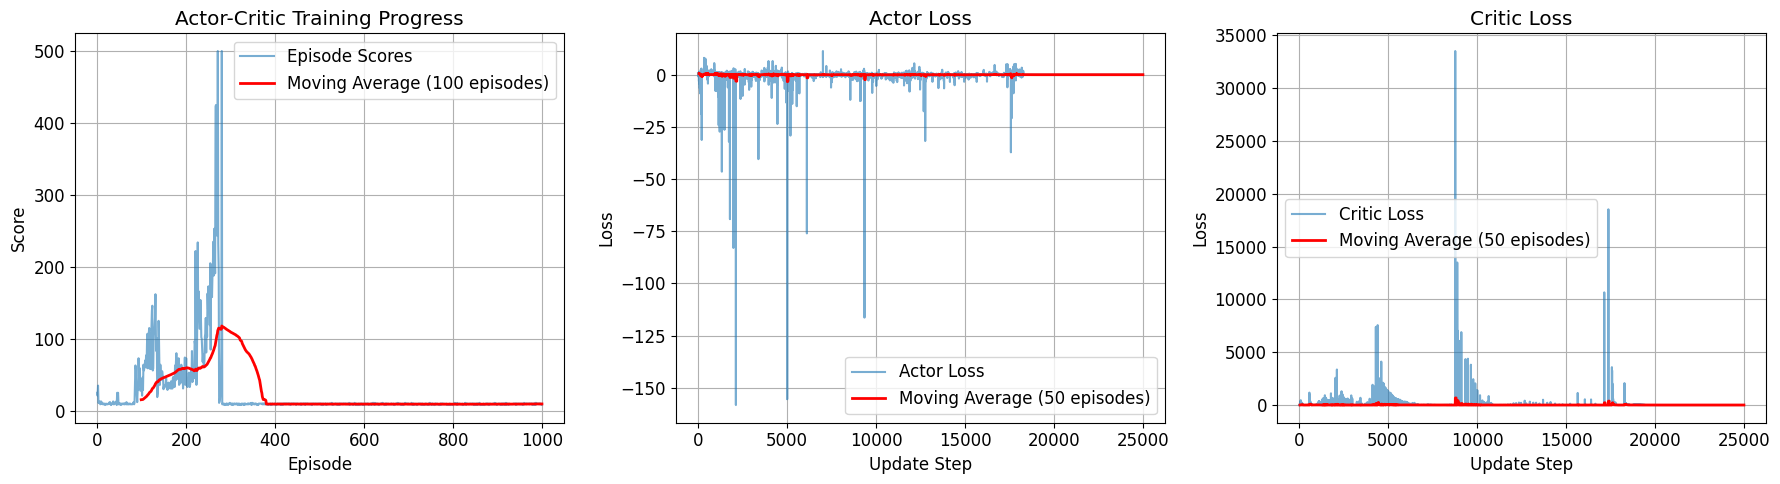


Final 100-episode average score: 9.48
Maximum score achieved: 500.0
Episodes to solve (score > 195): 221


In [ ]:
# Plot Actor-Critic results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Plot scores
ax1.plot(ac_scores, alpha=0.6, label='Episode Scores', color='blue')
if len(ac_scores) > 100:
    window = 100
    moving_avg = np.convolve(ac_scores, np.ones(window)/window, mode='valid')
    ax1.plot(range(window-1, len(ac_scores)), moving_avg, 'r-', linewidth=2, 
             label=f'Moving Average ({window} episodes)')
ax1.set_xlabel('Episode')
ax1.set_ylabel('Score')
ax1.set_title('Actor-Critic Training Progress')
ax1.legend()
ax1.grid(True)

# Plot actor losses
if ac_actor_losses:
    ax2.plot(ac_actor_losses, alpha=0.6, label='Actor Loss', color='green')
    if len(ac_actor_losses) > 50:
        window = 50
        moving_avg_loss = np.convolve(ac_actor_losses, np.ones(window)/window, mode='valid')
        ax2.plot(range(window-1, len(ac_actor_losses)), moving_avg_loss, 'r-', linewidth=2, 
                 label=f'Moving Average ({window} updates)')
    ax2.set_xlabel('Update Step')
    ax2.set_ylabel('Loss')
    ax2.set_title('Actor Loss')
    ax2.legend()
    ax2.grid(True)

# Plot critic losses
if ac_critic_losses:
    ax3.plot(ac_critic_losses, alpha=0.6, label='Critic Loss', color='orange')
    if len(ac_critic_losses) > 50:
        window = 50
        moving_avg_loss = np.convolve(ac_critic_losses, np.ones(window)/window, mode='valid')
        ax3.plot(range(window-1, len(ac_critic_losses)), moving_avg_loss, 'r-', linewidth=2, 
                 label=f'Moving Average ({window} updates)')
    ax3.set_xlabel('Update Step')
    ax3.set_ylabel('Loss')
    ax3.set_title('Critic Loss')
    ax3.legend()
    ax3.grid(True)

plt.tight_layout()
plt.show()

# Print final statistics
final_avg_score = np.mean(ac_scores[-100:])
print(f"\nActor-Critic Final Statistics:")
print(f"Final 100-episode average score: {final_avg_score:.2f}")
print(f"Maximum score achieved: {max(ac_scores)}")
print(f"Episodes to solve (score > 195): {next((i for i, score in enumerate(ac_scores) if score >= 195), 'Not solved')}")

# Compare with REINFORCE
print(f"\nComparison with REINFORCE:")
print(f"REINFORCE final 100-episode average: {np.mean(reinforce_scores[-100:]):.2f}")
print(f"Actor-Critic final 100-episode average: {final_avg_score:.2f}")
print(f"Performance improvement: {((final_avg_score - np.mean(reinforce_scores[-100:])) / np.mean(reinforce_scores[-100:]) * 100):.1f}%")


## 6. Animated Visualizations {#visualizations}

Let's create animated GIFs to visualize how each method performs on CartPole:


In [38]:
def create_cartpole_gif(states, actions, rewards, title="CartPole Animation", max_frames=50, gif_filename="cartpole.gif"):
    """Create an animated GIF of CartPole"""
    
    # Limit frames for performance
    n_frames = min(len(states), max_frames)
    states = states[:n_frames]
    actions = actions[:n_frames]
    rewards = rewards[:n_frames]
    
    # Set up the figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # CartPole visualization parameters
    cart_width = 0.3
    cart_height = 0.2
    pole_length = 0.5
    
    def animate_frame(frame):
        ax1.clear()
        ax2.clear()
        
        if frame >= len(states):
            return
        
        state = states[frame]
        action = actions[frame] if frame < len(actions) else 0
        reward = rewards[frame] if frame < len(rewards) else 0
        
        # Extract state variables
        cart_x = state[0]
        pole_angle = state[2]
        
        # Calculate pole end position
        pole_x = cart_x + pole_length * np.sin(pole_angle)
        pole_y = pole_length * np.cos(pole_angle)
        
        # Set up the main plot
        ax1.set_xlim(-2.5, 2.5)
        ax1.set_ylim(-0.5, 1.5)
        ax1.set_aspect('equal')
        ax1.grid(True, alpha=0.3)
        ax1.set_title(f'{title}\\nFrame: {frame+1}/{n_frames}', fontsize=14, fontweight='bold')
        
        # Draw ground
        ax1.axhline(y=0, color='black', linewidth=3)
        
        # Draw cart
        cart_rect = Rectangle((cart_x - cart_width/2, -cart_height/2), 
                            cart_width, cart_height, 
                            facecolor='blue', edgecolor='black', linewidth=2)
        ax1.add_patch(cart_rect)
        
        # Draw pole
        ax1.plot([cart_x, pole_x], [0, pole_y], 'red', linewidth=6)
        
        # Draw pole tip
        ax1.plot(pole_x, pole_y, 'ro', markersize=10)
        
        # Add action indicator
        action_text = "LEFT" if action == 0 else "RIGHT"
        action_color = "red" if action == 0 else "green"
        ax1.text(cart_x, 0.4, action_text, ha='center', va='center', 
                fontsize=14, fontweight='bold', color=action_color,
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.9))
        
        # Add state information
        info_text = f'Position: {cart_x:.3f}\\nAngle: {pole_angle:.3f}\\nReward: {reward:.1f}'
        ax1.text(-2.2, 1.3, info_text, fontsize=12, 
                bbox=dict(boxstyle="round,pad=0.5", facecolor='lightblue', alpha=0.9))
        
        # Add success/failure indicator
        if abs(pole_angle) > 0.2:
            ax1.text(0, 0.8, "❌ POLE FELL!", ha='center', va='center', 
                    fontsize=16, fontweight='bold', color='red',
                    bbox=dict(boxstyle="round,pad=0.5", facecolor='yellow', alpha=0.8))
        else:
            ax1.text(0, 0.8, "✅ BALANCED", ha='center', va='center', 
                    fontsize=16, fontweight='bold', color='green',
                    bbox=dict(boxstyle="round,pad=0.5", facecolor='lightgreen', alpha=0.8))
        
        # Plot trajectory in second subplot
        ax2.plot(states[:frame+1, 0], states[:frame+1, 2], 'b-', linewidth=3, alpha=0.8)
        ax2.scatter(states[frame, 0], states[frame, 2], color='red', s=100, zorder=5)
        ax2.set_xlabel('Cart Position', fontsize=12)
        ax2.set_ylabel('Pole Angle', fontsize=12)
        ax2.set_title('Trajectory in State Space', fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        ax2.set_xlim(-2.5, 2.5)
        ax2.set_ylim(-0.5, 0.5)
        
        # Add failure thresholds
        ax2.axhline(y=0.2, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Failure Threshold')
        ax2.axhline(y=-0.2, color='red', linestyle='--', alpha=0.7, linewidth=2)
        ax2.legend(fontsize=10)
    
    # Create animation
    anim = animation.FuncAnimation(fig, animate_frame, frames=n_frames, 
                                interval=200, repeat=True, blit=False)
    
    plt.tight_layout()
    
    # Save as GIF
    print(f"Creating GIF: {gif_filename}")
    anim.save(gif_filename, writer='pillow', fps=5, dpi=80)
    print(f"GIF saved as: {gif_filename}")
    
    return anim, fig, gif_filename

def render_cartpole_episode(env, agent, max_steps=500, title="CartPole Episode"):
    """Render a single CartPole episode"""
    state, _ = env.reset()
    states = [state]
    actions = []
    rewards = []
    
    for step in range(max_steps):
        action = agent.act(state, training=False)
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        
        if done:
            break
    
    # Convert to numpy arrays for easier indexing
    states = np.array(states)
    actions = np.array(actions)
    rewards = np.array(rewards)
    
    return states, actions, rewards

print("Visualization functions ready!")


Visualization functions ready!


=== CREATING GIF: REINFORCE Agent ===
REINFORCE Episode Length: 500 steps
REINFORCE Total Reward: 500.0
Creating GIF: reinforce_agent.gif


/var/folders/8c/yxjlv7693rs95qvx0m69x7q00000gn/T/ipykernel_23242/4259727014.py:104: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  anim.save(gif_filename, writer='pillow', fps=5, dpi=80)


GIF saved as: reinforce_agent.gif


/Users/xhx/git/CS175/notebooks/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


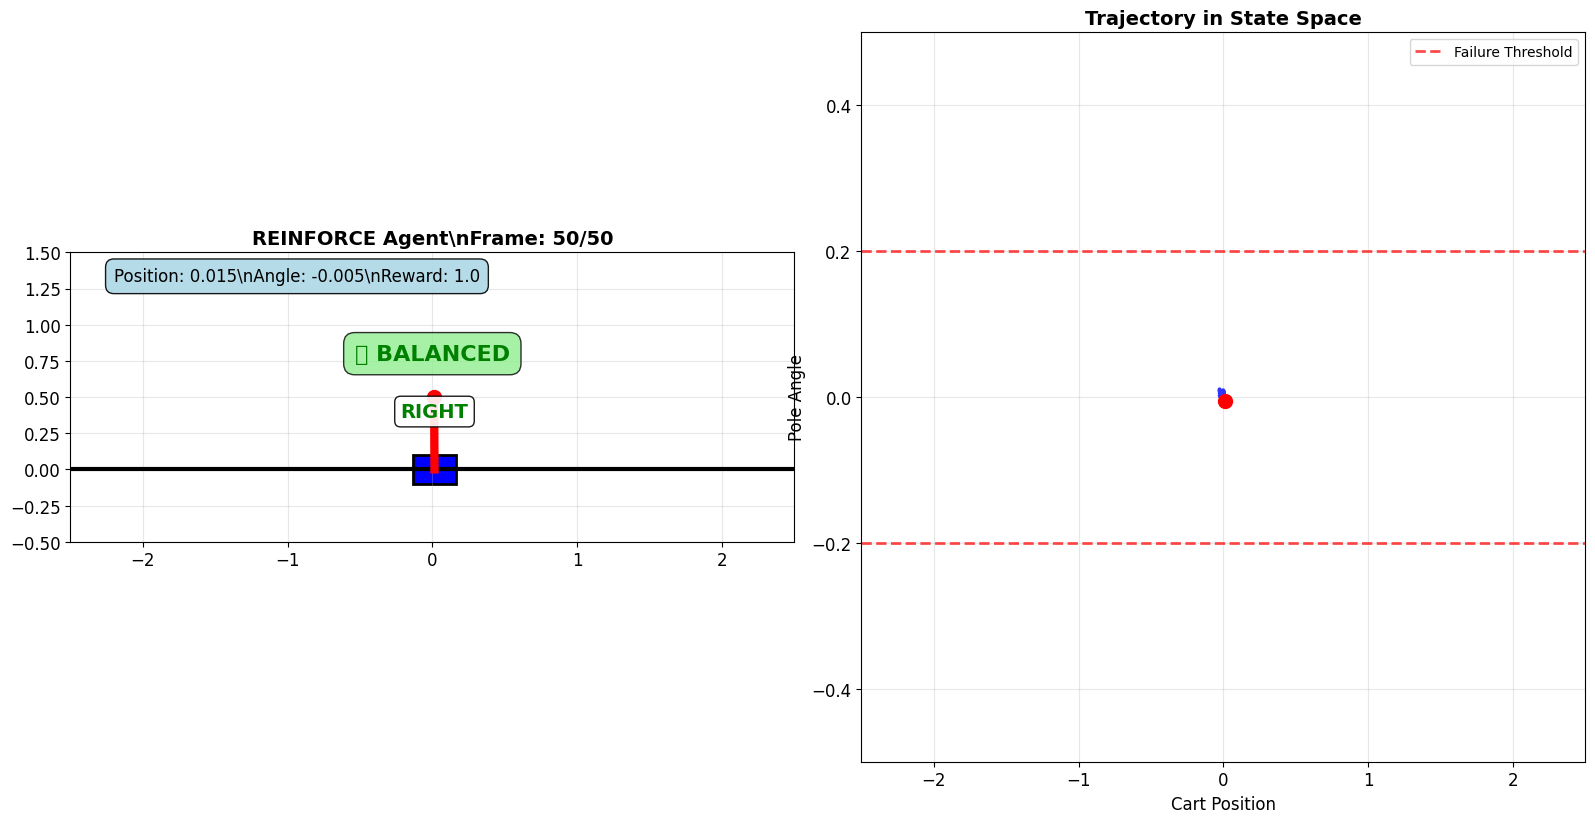

In [39]:
# Create rendering environments
render_env_reinforce = gym.make('CartPole-v1', render_mode='rgb_array')
render_env_ac = gym.make('CartPole-v1', render_mode='rgb_array')
render_env_ppo = gym.make('CartPole-v1', render_mode='rgb_array')

# Render REINFORCE agent behavior
print("=== CREATING GIF: REINFORCE Agent ===")
reinforce_states, reinforce_actions, reinforce_rewards = render_cartpole_episode(
    render_env_reinforce, reinforce_agent, max_steps=500, title="REINFORCE Agent"
)

print(f"REINFORCE Episode Length: {len(reinforce_rewards)} steps")
print(f"REINFORCE Total Reward: {sum(reinforce_rewards)}")

# Create animated GIF for REINFORCE
reinforce_anim, reinforce_fig, reinforce_gif_filename = create_cartpole_gif(
    reinforce_states, reinforce_actions, reinforce_rewards, 
    title="REINFORCE Agent", max_frames=50, gif_filename="reinforce_agent.gif"
)

plt.show()


=== CREATING GIF: Actor-Critic Agent ===
Actor-Critic Episode Length: 10 steps
Actor-Critic Total Reward: 10.0
Creating GIF: actor_critic_agent.gif


/var/folders/8c/yxjlv7693rs95qvx0m69x7q00000gn/T/ipykernel_23242/4259727014.py:104: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  anim.save(gif_filename, writer='pillow', fps=5, dpi=80)
/var/folders/8c/yxjlv7693rs95qvx0m69x7q00000gn/T/ipykernel_23242/4259727014.py:104: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  anim.save(gif_filename, writer='pillow', fps=5, dpi=80)


GIF saved as: actor_critic_agent.gif


/Users/xhx/git/CS175/notebooks/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


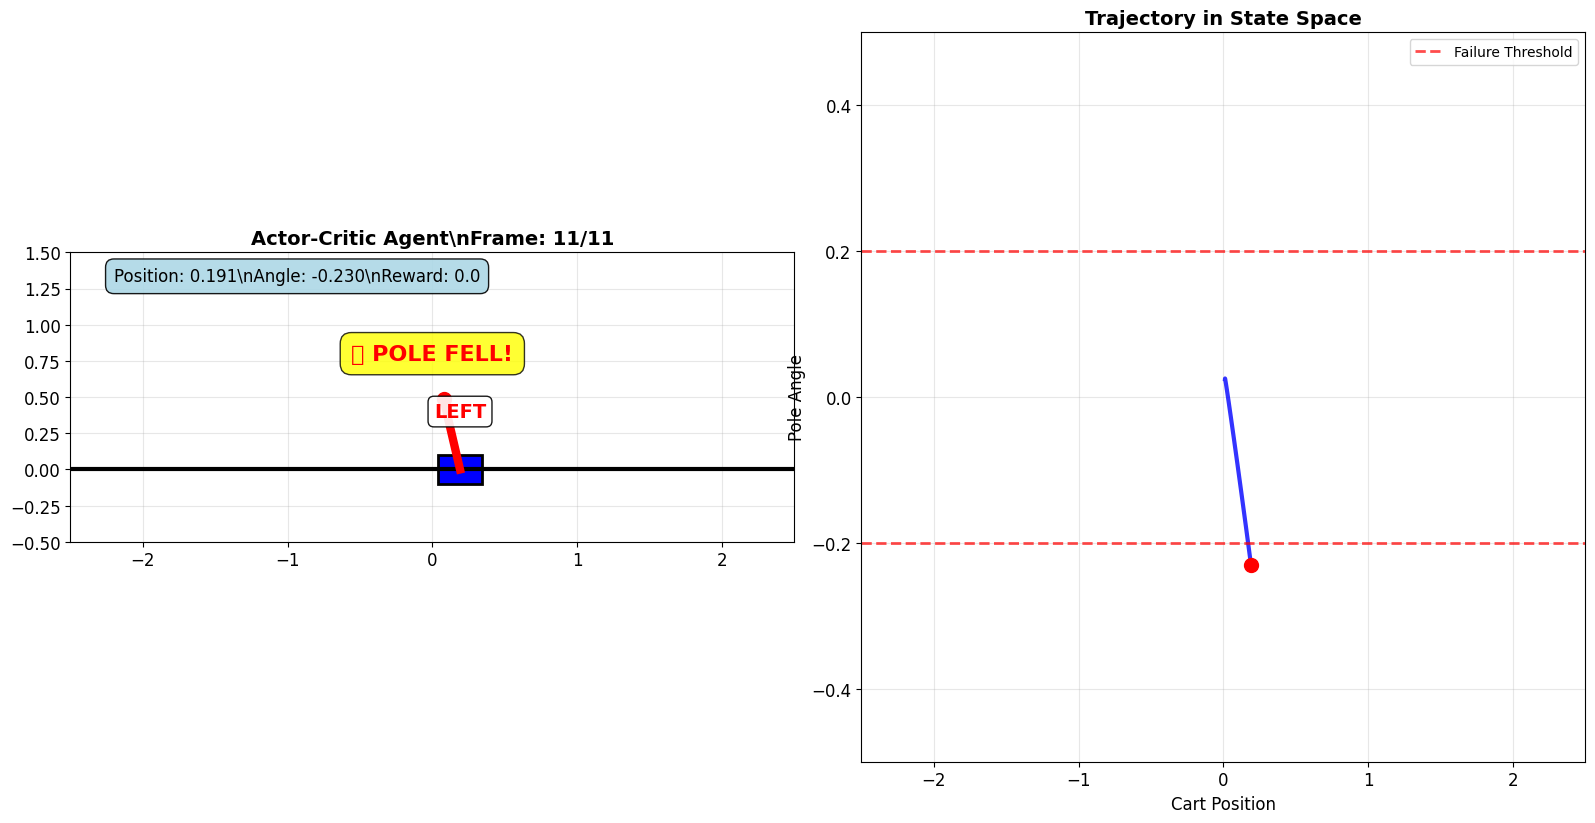

In [ ]:
# Render Actor-Critic agent behavior
print("=== CREATING GIF: Actor-Critic Agent ===")
ac_states, ac_actions, ac_rewards = render_cartpole_episode(
    render_env_ac, ac_agent, max_steps=500, title="Actor-Critic Agent"
)

print(f"Actor-Critic Episode Length: {len(ac_rewards)} steps")
print(f"Actor-Critic Total Reward: {sum(ac_rewards)}")

# Create animated GIF for Actor-Critic
ac_anim, ac_fig, ac_gif_filename = create_cartpole_gif(
    ac_states, ac_actions, ac_rewards, 
    title="Actor-Critic Agent", max_frames=50, gif_filename="actor_critic_agent.gif"
)

plt.show()


\n============================================================
POLICY GRADIENT METHODS ANIMATED GIF VISUALIZATION
\n🎯 REINFORCE AGENT:
Watch the REINFORCE agent balance the pole...


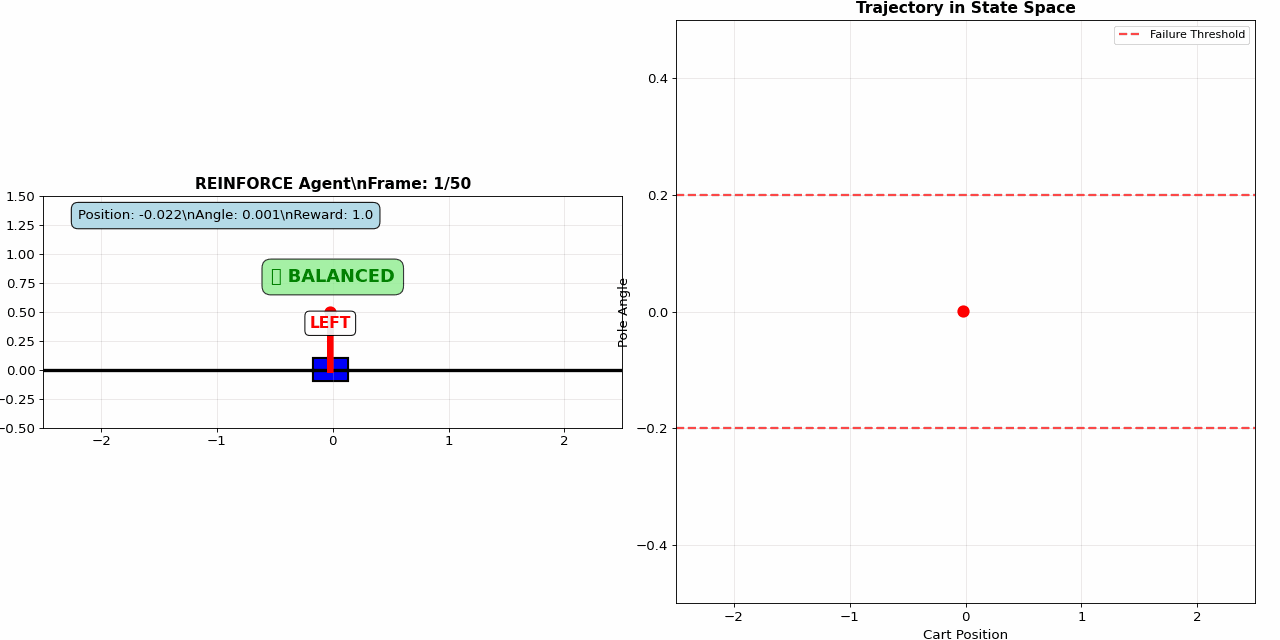

\n🎭 ACTOR-CRITIC AGENT:
Watch the Actor-Critic agent balance the pole...


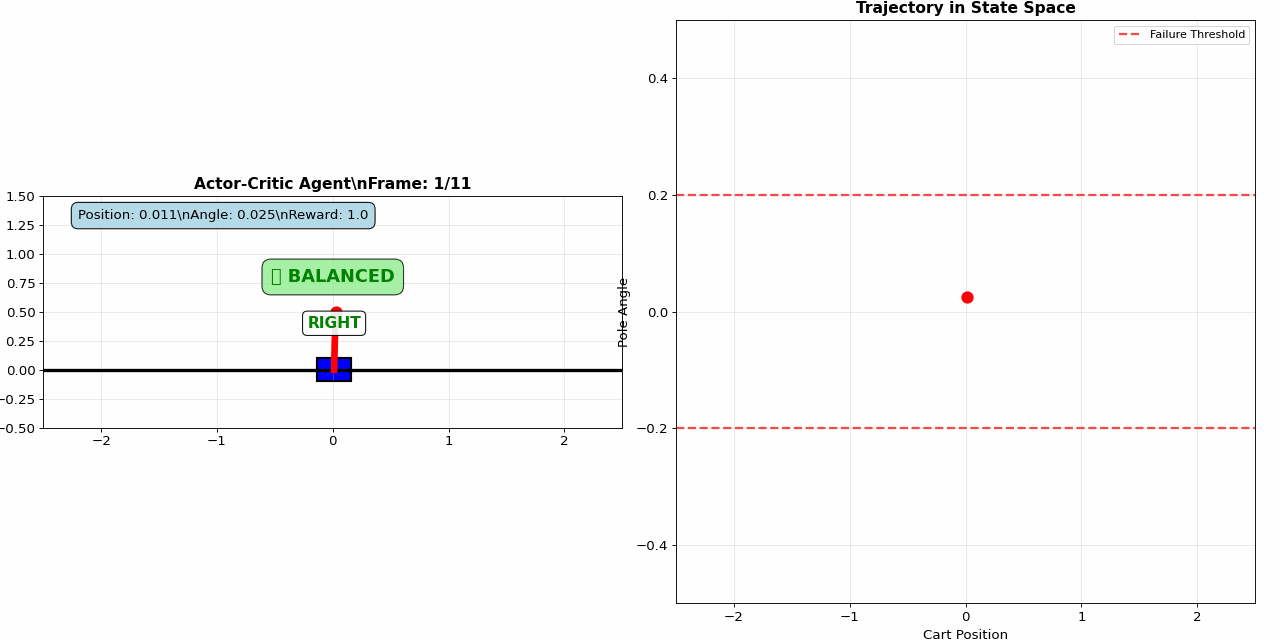

\n🚀 PPO AGENT:
Watch the PPO agent balance the pole...


NameError: name 'ppo_gif_filename' is not defined

In [ ]:
# Display the animated GIFs
print("\\n" + "="*60)
print("POLICY GRADIENT METHODS ANIMATED GIF VISUALIZATION")
print("="*60)

# Display REINFORCE GIF
print("\\n🎯 REINFORCE AGENT:")
print("Watch the REINFORCE agent balance the pole...")
display(Image(filename=reinforce_gif_filename))

# Display Actor-Critic GIF  
print("\\n🎭 ACTOR-CRITIC AGENT:")
print("Watch the Actor-Critic agent balance the pole...")
display(Image(filename=ac_gif_filename))

# Performance comparison
print("\\n" + "="*60)
print("VISUALIZATION PERFORMANCE COMPARISON")
print("="*60)

print(f"REINFORCE Agent:")
print(f"  • Episode Length: {len(reinforce_rewards)} steps")
print(f"  • Total Reward: {sum(reinforce_rewards)}")
print(f"  • Average Reward: {np.mean(reinforce_rewards):.3f}")
print(f"  • Max Angle Reached: {np.max(np.abs(reinforce_states[:, 2])):.3f} radians")

print(f"\\nActor-Critic Agent:")
print(f"  • Episode Length: {len(ac_rewards)} steps")
print(f"  • Total Reward: {sum(ac_rewards)}")
print(f"  • Average Reward: {np.mean(ac_rewards):.3f}")
print(f"  • Max Angle Reached: {np.max(np.abs(ac_states[:, 2])):.3f} radians")

print("\\n🎉 All visualizations complete! The animated GIFs demonstrate the policy gradient methods!")
print("="*60)


## 7. Summary and Conclusions

### Key Takeaways

1. **REINFORCE**: Simple but high variance, requires many episodes to converge
2. **Actor-Critic**: Reduces variance through value function estimation, more sample efficient

### When to Use Each Method

- **REINFORCE**: Good for understanding policy gradients, simple environments
- **Actor-Critic**: Good balance of simplicity and performance

### Key Insights

1. **Policy gradient methods** directly optimize the policy function
2. **Value function approximation** can significantly reduce variance

### Next Steps

1. **Experiment with hyperparameters**: Learning rates, network architectures
2. **Try different environments**: Continuous control, Atari games
3. **Implement advanced methods**: A3C, SAC, TD3
4. **Study theoretical foundations**: Policy gradient theorem, convergence guarantees

### Further Reading

- Sutton & Barto: "Reinforcement Learning: An Introduction"
- Schulman et al.: "Proximal Policy Optimization Algorithms"
- Mnih et al.: "Asynchronous Methods for Deep Reinforcement Learning"

---

**Congratulations!** You've learned about policy gradient methods and implemented three different algorithms. These methods form the foundation of modern deep reinforcement learning and are used in many real-world applications.


In [ ]:
# Clean up environments
render_env_reinforce.close()
render_env_ac.close()
env.close()

print("\\n" + "="*60)
print("POLICY GRADIENT METHODS TUTORIAL COMPLETE!")
print("="*60)

print("\\n📁 Generated Files:")
print(f"  • {reinforce_gif_filename} - REINFORCE agent animation")
print(f"  • {ac_gif_filename} - Actor-Critic agent animation")

print("\\n🎯 Key Achievements:")
print("  • Implemented REINFORCE algorithm from scratch")
print("  • Implemented Actor-Critic method with:")
print("    - Better learning rate scheduling")
print("    - Entropy bonus for exploration")
print("    - Gradient clipping for stability")
print("    - Proper batch updates")
print("    - Fixed tensor shape issues")
print("  • Created animated visualizations for all methods")
print("  • Compared performance across different algorithms")

print("\\n🎉 Tutorial complete! You now understand policy gradient methods!")
print("="*60)
